text: Apple 	lemma: Apple	upos: PROPN	xpos: NNP
text: is 	lemma: be	upos: AUX	xpos: VBZ
text: looking 	lemma: look	upos: VERB	xpos: VBG
text: at 	lemma: at	upos: SCONJ	xpos: IN
text: buying 	lemma: buy	upos: VERB	xpos: VBG
text: U.K. 	lemma: U.K.	upos: PROPN	xpos: NNP
text: startup 	lemma: startup	upos: NOUN	xpos: NN
text: for 	lemma: for	upos: ADP	xpos: IN
text: $ 	lemma: $	upos: SYM	xpos: $
text: 1 	lemma: 1	upos: NUM	xpos: CD
text: billion 	lemma: billion	upos: NUM	xpos: CD
text: . 	lemma: .	upos: PUNCT	xpos: .
('Apple', '3', 'nsubj')
('is', '3', 'aux')
('looking', '0', 'root')
('at', '5', 'mark')
('buying', '3', 'advcl')
('U.K.', '7', 'compound')
('startup', '5', 'obj')
('for', '9', 'case')
('$', '5', 'obl')
('1', '11', 'compound')
('billion', '9', 'nummod')
('.', '3', 'punct')


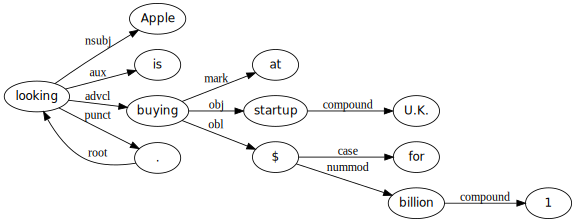

In [58]:
from sagas.nlu.corenlp_helper import LangDialect as dia
dia('en').ana_s('Apple is looking at buying U.K. startup for $1 billion.')

In [19]:
import spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [51]:
import sagas
sents='Apple is looking at buying U.K. startup for $1 billion.'

# document level
def entity_df(sents):
    doc=spacy_nlp(sents)
    rs=[]
    for ent in doc.ents:
        rs.append((ent.text, ent.start_char, ent.end_char, ent.label_))
    return sagas.to_df(rs, ['word', 'start', 'end', 'entity'])

def entity_positions(sents):
    doc=spacy_nlp(sents)
    rs=[]
    for ent in doc.ents:
        rs.append({'text':ent.text, 'start':ent.start_char, 'end':ent.end_char, 'entity':ent.label_})
    return rs

# token level
def token_entity_df(sents):
    doc=spacy_nlp(sents)
    rs=[]
    for ent in doc:
        rs.append((ent.i, ent.idx, ent.text, ent.ent_type_, ent.ent_iob_, 
                   [ent.is_punct, ent.like_num]))
    return sagas.to_df(rs, ['index', 'position', 'word', 'entity', 'iob', 'feat'])

# entity_df(sents)
token_entity_df(sents)

,index,position,word,entity,iob,feat
0,0,0,Apple,ORG,B,"[False, False]"
1,1,6,is,,O,"[False, False]"
2,2,9,looking,,O,"[False, False]"
3,3,17,at,,O,"[False, False]"
4,4,20,buying,,O,"[False, False]"
5,5,27,U.K.,GPE,B,"[False, False]"
6,6,32,startup,,O,"[False, False]"
7,7,40,for,,O,"[False, False]"
8,8,44,$,MONEY,B,"[False, False]"
9,9,45,1,MONEY,I,"[False, True]"


In [5]:
import sagas.tool.misc as misc
data = {'lang': 'en', "sents": sents}
df_set=misc.get_verb_domains(data, True)
for df in df_set:
    display(df)

✔ looking 3
✔ buying 5


,rel,index,text,children,features
0,nsubj,1,Apple,[Apple],[c_apple_propn]
1,aux,2,is,[is],[c_be_aux]
2,advcl,5,buying,"[1, billion, at, buying, U.K., startup, for, $]",[c_buy_verb]
3,punct,12,.,[.],[c_._punct]


,rel,index,text,children,features
0,mark,4,at,[at],[c_at_sconj]
1,obj,7,startup,"[U.K., startup]",[c_startup_noun]
2,obl,9,$,"[1, billion, for, $]",[c_$_sym]


In [37]:
import sagas

def equals(a, b):
    return str(a) == str(b)

def get_children(sent, word, rs):
    for c in filter(lambda w: equals(w.governor, word.index), sent.words):
        rs.append((c.index, c.text))
        get_children(sent, c, rs)

def get_children_list(sent, word, include_self=True):
    rs = []
    get_children(sent, word, rs)
    if include_self:
        rs.append((word.index, word.text))
    # sort by word's index
    rs=sorted(rs, key=lambda _: int(_[0]))
    result = [w[1] for w in rs]
    positions=[int(w[0]) for w in rs]
    # if include_self:
    #     result.append(word.text)
    return result, positions

def get_word_features(word):
    # 'c' represent a chunk
    return ['c_{}_{}'.format(word.lemma, word.upos).lower()]

def get_verb_domain(sent, filters):
    rs = []
    for word in filter(lambda w: w.upos == "VERB", sent.words):
        # if money.dep_ in ("attr", "dobj"):
        # print(word.index, word.text)
        domains = []
        for c in filter(lambda w: equals(w.governor, word.index), sent.words):
            # print('\t', c.index, c.text, get_children_list(sent, c))
            children, positions=get_children_list(sent, c)
            domains.append((c.dependency_relation, c.index, c.text,
                            children, positions, get_word_features(c)))
        rs.append({'type':'verb_domains', 'verb': word.text, 'index': word.index,
                   'domains': domains})
    return rs

def print_words(sent):
    rs=[]
    for word in sent.words:
        # print(word.index, word.text)
        rs.append((word.index, word.text))
    rs=sorted(rs, key=lambda _: int(_[0]))
    result = [w[1] for w in rs]
    print(result)
    
from sagas.nlu.corenlp_helper import CoreNlp, CoreNlpViz, get_nlp

sents='Apple is looking at buying U.K. startup for $1 billion.'
nlp = get_nlp('en')
doc=nlp(sents)
print(sents)
print_words(doc.sentences[0])
r=get_verb_domain(doc.sentences[0], [])
print(r[0]['verb'])
sagas.to_df(r[0]['domains'], ['rel', 'index', 'text', 'children', 'positions', 'feat'])

Apple is looking at buying U.K. startup for $1 billion.
['Apple', 'is', 'looking', 'at', 'buying', 'U.K.', 'startup', 'for', '$', '1', 'billion', '.']
looking


,rel,index,text,children,positions,feat
0,nsubj,1,Apple,[Apple],[1],[c_apple_propn]
1,aux,2,is,[is],[2],[c_be_aux]
2,advcl,5,buying,"[at, buying, U.K., startup, for, $, 1, billion]","[4, 5, 6, 7, 8, 9, 10, 11]",[c_buy_verb]
3,punct,12,.,[.],[12],[c_._punct]


In [5]:
['x','y'] in ['x','z','y']

False

In [54]:
def in_range(element, container):
    return element[0]>=container[0] and element[1]<=container[1]
print(in_range((0,5), (0,5)))
print(in_range((10,15), (10,16)))

True
True


In [60]:
class Token(object):
    def __init__(self, index, word, word_offset, positions):
        self.index=index
        self.word=word
        self.word_offset=word_offset
        self.positions=positions
        
    def __str__(self): 
        return '%s %s' % (self.word, self.positions)
    
def tokenize(text, sent):    
    running_offset = 0
    tokens = []
    positions = []
    
    for doc_word in sent.words:
        word=doc_word.text
        word_offset = text.index(word, running_offset)
        word_len = len(word)
        running_offset = word_offset + word_len
        tokens.append(Token(doc_word.index, word, word_offset, {"start":word_offset, "end":running_offset}))
    return tokens

def get_included_entities(word_range, ent_pos):
    rs=[]
    for ent in ent_pos:
        if in_range((ent['start'],ent['end']), word_range):
            rs.append(ent)
    return rs
doc_s=doc.sentences[0]
tokens=tokenize(sents, doc_s)
for tok in tokens:
    print(tok.index, '\t', tok.word, tok.word_offset, tok.positions)
ent_pos=entity_positions(sents)
print(ent_pos)
# process spans and overlaps 
chunks=[]
for el in r[0]['domains']:
    span_id=el[0]
    span_pos=el[4]
    start_mark=tokens[span_pos[0]-1]
    end_mark=tokens[span_pos[-1]-1]
    word_range=[start_mark.positions['start'], end_mark.positions['end']]
    entities=get_included_entities(word_range, ent_pos)
    chunks.append((span_id, span_pos, word_range, 
          sents[word_range[0]:word_range[1]],
          [ent['entity'] for ent in entities]
         ))
df=sagas.to_df(chunks, ['rel', 'positions', 'range', 'chunk text', 'entities'])
df[['rel', 'chunk text', 'entities']]

1 	 Apple 0 {'start': 0, 'end': 5}
2 	 is 6 {'start': 6, 'end': 8}
3 	 looking 9 {'start': 9, 'end': 16}
4 	 at 17 {'start': 17, 'end': 19}
5 	 buying 20 {'start': 20, 'end': 26}
6 	 U.K. 27 {'start': 27, 'end': 31}
7 	 startup 32 {'start': 32, 'end': 39}
8 	 for 40 {'start': 40, 'end': 43}
9 	 $ 44 {'start': 44, 'end': 45}
10 	 1 45 {'start': 45, 'end': 46}
11 	 billion 47 {'start': 47, 'end': 54}
12 	 . 54 {'start': 54, 'end': 55}
[{'text': 'Apple', 'start': 0, 'end': 5, 'entity': 'ORG'}, {'text': 'U.K.', 'start': 27, 'end': 31, 'entity': 'GPE'}, {'text': '$1 billion', 'start': 44, 'end': 54, 'entity': 'MONEY'}]


,rel,chunk text,entities
0,nsubj,Apple,[ORG]
1,aux,is,[]
2,advcl,at buying U.K. startup for $1 billion,"[GPE, MONEY]"
3,punct,.,[]
